In [ ]:
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

The plugin extension is already loaded. To reload it, use:
  %reload_ext plugin


# **Video Demo**
Explantion: In these video we show how the system works and how it gathers data,processes it and provides us with a 24-bit random number to be sent to the Raspberry pi to be showcased


Link to physical test

https://www.youtube.com/watch?v=RqVWFEaKl3I


# State machine and module explanation

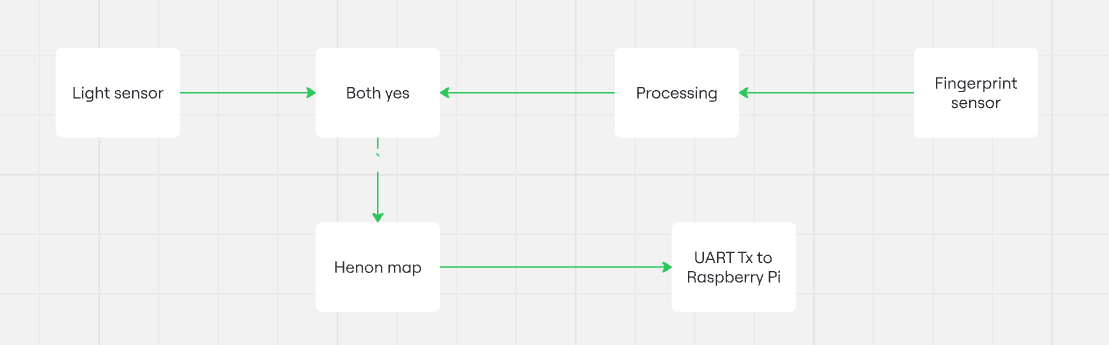
Fig 1: state checking

The FPGA checks the outputs of both the processing and the light sensor to see if it has completed it's tasks. This then allows us to send the data to the Henon map which will do it's PRN generation. After it is completed, the Henon map module will send a signal to the UART Tx module, which sends the 24-bits of data from the FPGA to the Raspberry Pi.

The ADC reader and the Clk divider was done and reviewed in Lab 3 and as such will not be covered in this report.

The UART was recreated to allow for simple edits from our side. This allowed us to view the state and be able to determine if infomation was being sent and received.

The Henon map takes 2 32-bit data and uses it to simulate a chaotic system, which we explored more in depth with the report.

# **Logic-gate Code**

For the logic gate FPGA, our code used in the program is shown below. It was created by TA Mao Yang to test the CMOD FPGA being used in the current iteration


In [ ]:
module Top(
    input sysclk,
    input rst_n,
    input pio1,
    output pio2,
    output adc_din,
        output adc_clk,
        output adc_csn,
    input  adc_dout,
    output [1:0] led,
    output pio7,
    output pio8
);

parameter CLK_FREQ = 12_000_000;
   parameter RX_BAUD = 57_600;
    parameter TX_BAUD = 9_600;
    parameter TOTAL_BYTES = 50;
wire [7:0] rx_data;
wire rx_done;
wire [31:0] avg_value;
reg [31:0] Segment_data;
wire avg_done;
wire tx_busy;
reg [7:0] tx_data;
wire CLK1Hz;
wire clk2Mhz;
reg start;
wire adc_vaild;
assign pio7 = avg_done;
assign pio8 = start;
assign led = tx_state;

localparam  SINGLE_CHAN0  = 2'b10;
localparam  SINGLE_CHAN1  = 2'b11;

reg adc_ready;
wire [11:0] adc_data;

// Clk divder to get the 2Mhz for ADC
clock_div u1( rst_n,sysclk,clk2Mhz);
clock_div u2(rst_n,sysclk,CLK1Hz);

defparam u2.FREQ_OUTPUT = 500;


drv_mcp3202 drv_mcp3202_u0(
    .rstn(rst_n),
    .clk(clk2Mhz),
    .ap_ready(adc_ready),
    .ap_vaild(adc_vaild),
    .mode(SINGLE_CHAN0),
    .data(adc_data),

    .port_din(adc_dout),
    .port_dout(adc_din), //adc_din
    .port_clk(adc_clk),
    .port_cs(adc_csn)
);

// ADC SAMPLING EVENT (FREQ:1HZ)
always @(posedge rst_n, posedge adc_vaild,posedge CLK1Hz) begin
    if(rst_n) begin
        adc_ready <= 1'b0;
        Segment_data <= 32'h0;
    end else begin
        if(adc_vaild) begin
            Segment_data <= adc_data;
            adc_ready <= 1'b0;
        end
        else begin
            adc_ready <= 1'b1;
        end
    end
end
// UART RX Instance (57.6k baud)
UART_RX rx_inst (
    .clk(sysclk),
    .FPGA_RX(pio1),
    .rx_data(rx_data),
    .rx_done(rx_done)
);

// Average Calculator
fingerprint_mean_processing avg_inst (
    sysclk,
    clk2Mhz,
    rst_n,
    pio1,
    avg_value,
    avg_done
    );

// UART TX Instance (9.6k baud)
UART_TX tx_inst (
    .clk(sysclk),
    .tx_start(tx_start),
    .tx_data(tx_data),
    .tx(pio2),
    .tx_done(tx_busy)
);

//sample for both starts
always @(posedge sysclk) begin
 if (avg_done) begin
 start <= 1'b1;
 end
 else begin
 start <= 0;
 end
 end

//initialize henonmap
//reg [31:0] a;
//reg [31:0] b;
wire Henon_done;
wire [31:0] x_out;
wire [31:0] y_out;

//initial begin
//a = 14;
//b= 3;
//end
//henon_map_q31 q1(clk2Mhz, rst_n, start, avg_value, Segment_data,a,b,x_out,y_out,Henon_done);

henon_prng_top #(
    .TOTAL_ITER(8)
) prng_inst(
    .clk(clk2Mhz),
    .rst(rst_n),
    .start(start),
    .seed_q31(adc_data),
    .fingerprint_mean(avg_value),
    .random_out_x(x_out),
    .random_out_y(y_out),
    .done(Henon_done)
);

reg [1:0] henon_count;
// 32-bit Transmission Control
reg [31:0] tx_buffer;
reg [2:0] tx_state;
reg [1:0] byte_count;
reg tx_start;
reg [2:0] tx_state;



localparam TX_IDLE  = 2'b01,
           TX_START = 2'b10,
           TX_WAIT  = 2'b11;



always @(posedge sysclk or posedge rst_n) begin
    if(rst_n) begin
        henon_count <= 0;
        tx_state <= TX_IDLE;
        byte_count <= 0;
        tx_start <= 0;
        tx_data <= 8'h00;
        tx_buffer <= 32'h00000000;
    end
    else begin
        case(tx_state)
            TX_IDLE: begin
                if(Henon_done & tx_buffer!=x_out) begin
                    tx_buffer <= x_out;
                    tx_state <= TX_START;
                    byte_count <= 0;
                end
            end

            TX_START: begin
                case(byte_count)
                    2'b00: tx_data <= tx_buffer[15:8];
                    2'b01: tx_data <= tx_buffer[23:16];
                    2'b10: tx_data <= tx_buffer[31:24];
                endcase
                tx_start <= 1'b1;
                tx_state <= TX_WAIT;
            end

            TX_WAIT: begin
                tx_start <= 1'b0;
                if(!tx_busy) begin
                    // Wait for transmission to start
                    tx_state <= TX_WAIT;
                end else begin
                    // Transmission complete
                    if(byte_count == 2'b11) begin
                        tx_state <= TX_IDLE;
                    end else begin
                        byte_count <= byte_count + 1'b1;
                        tx_state <= TX_START;
                    end
                end
            end
        endcase
    end
end



endmodule

In [ ]:
module fingerprint_mean_processing(
input sysclk,
    input clk,
    input rst_n,
    input uart_rx,
    output reg [31:0] avg_out,
    output reg done_avg
);

// UART RX Interface
wire [7:0] rx_data;
wire rx_done;
parameter TOTAL_BYTES = 50;
parameter CLK_FREQ = 12_000_000;
parameter BAUD_RATE = 57_600;
parameter MAX_SUM_THRESHOLD = 12750;

// UART RX Instantiation
 UART_RX uart_rx_inst (
    .clk(sysclk),
    .FPGA_RX(uart_rx),
    .rx_data(rx_data),
    .rx_done(rx_done)
);

// Expanded registers for 32-bit output
reg [31:0] sum;
reg [14:0] byte_count;
reg [1:0] state;

// Modified division parameters
localparam DIVIDE_CYCLES = 63;  //
reg [5:0] div_counter;          // 6 bits
reg [47:0] dividend;            // 48-bit dividend
reg [15:0] divisor;
reg [31:0] quotient;            // 32-bit quotient

// State definitions
localparam IDLE = 2'b00,
           ACCUMULATE = 2'b01,
           CALC_AVG = 2'b10;

always @(posedge clk or posedge rst_n) begin
    if(rst_n) begin
        sum <= 32'b0;
        byte_count <= 15'b0;
        avg_out <= 32'b0;
        done_avg <= 1'b0;
        state <= IDLE;
        dividend <= 48'b0;
        divisor <= 16'b0;
        quotient <= 32'b0;
        div_counter <= 6'b0;
    end
    else begin
        case(state)
            IDLE: begin
                if(rx_done) begin
                    sum <= rx_data;       // Initial sum with sign extension
                    byte_count <= 15'b1;
                    done_avg <= 1'b0;
                    div_counter <= 6'b0;
                    state <= ACCUMULATE;
                end
            end

            ACCUMULATE: begin
                if(rx_done & rx_data != 8'hFF & rx_data != 8'h00) begin
                    sum <= sum + rx_data;  // 32-bit accumulation
                    byte_count <= byte_count + 1'b1;
                end

                if(byte_count == TOTAL_BYTES) begin
                    if (sum <= MAX_SUM_THRESHOLD) begin
                        dividend <= {sum, 16'b0};  // 48-bit dividend for fixed-point
                        divisor <= TOTAL_BYTES;
                        state <= CALC_AVG;
                    end else begin
                        done_avg <= 1'b0;
                        state <= IDLE;
                    end
                end
            end

            CALC_AVG: begin
                if(div_counter < DIVIDE_CYCLES) begin
                    // Modified division for 48-bit dividend
                    if(dividend[47:32] >= divisor) begin
                        dividend <= {dividend[47:32] - divisor, dividend[31:0], 1'b1};
                        quotient <= {quotient[30:0], 1'b1};
                    end else begin
                        dividend <= {dividend[46:0], 1'b0};
                        quotient <= {quotient[30:0], 1'b0};
                    end
                    div_counter <= div_counter + 1'b1;
                end else begin
                    avg_out <= quotient;  // Full 32-bit output
                    done_avg <= 1'b1;
                    state <= IDLE;
                end
            end
        endcase
    end
end

endmodule

In [ ]:
module henon_prng_top (
    input wire clk,
    input wire rst,
    input wire start,
    input wire [31:0] seed_q31,
    input wire [31:0] fingerprint_mean, // 32-bit mean in Q1.31
    output reg [31:0] random_out_x,   // Final 32-bit x output in Q1.31
    output reg [31:0] random_out_y,   // Final 32-bit y output in Q1.31
    output reg done
);

    // 1.4 in decimal => ~0xB3333333 in Q1.31
    // 0.3 in decimal => ~0x26666666 in Q1.31
    localparam signed [31:0] A_Q31 = 32'hB3333333;  // ~1.4
    localparam signed [31:0] B_Q31 = 32'h26666666;  // ~0.3

    //--------------------------------------------------------------------
    // Internal regs
    //--------------------------------------------------------------------
    reg [1:0] state;
    reg [31:0] x, y;          // current x,y in Q1.31
    reg iter_start;           // single-cycle pulse to henon_map_q31
    reg [7:0] iter_count;
    wire iter_done;
    wire signed [31:0] x_next, y_next;

    // We'll do a rising-edge detect on iter_done
    reg iter_done_d;
    wire iter_done_rising = iter_done & ~iter_done_d;

    parameter TOTAL_ITER = 8;
    //--------------------------------------------------------------------
    // Henon iteration module (one iteration per start pulse)
    //--------------------------------------------------------------------
    henon_map_q31 iter_unit (
        .clk(clk),
        .rst(rst),
        .start(iter_start),
        .x_in(x),
        .y_in(fingerprint_mean), // use fingerprint_mean as initial y
        .a(A_Q31),
        .b(B_Q31),
        .x_out(x_next),
        .y_out(y_next),
        .done(iter_done)
    );

    //--------------------------------------------------------------------
    // FSM states
    //--------------------------------------------------------------------
    localparam IDLE = 2'd0,
               RUN  = 2'd1,
               WAIT = 2'd2,
               DONE_ST = 2'd3;



    //--------------------------------------------------------------------
    // Main FSM
    //--------------------------------------------------------------------
    always @(posedge clk or posedge rst) begin
        if (rst) begin
            state <= IDLE;
            done <= 0;
            iter_start <= 0;
            iter_count <= 0;
            x <= 0;
            y <= 0;
            random_out_x <= 0;
            random_out_y <= 0;
            iter_done_d <= 0;
        end else begin
            iter_done_d <= iter_done; // rising-edge track

            case (state)
                IDLE: begin
                    iter_start <= 0;
                    done <= 0;
                    if (start) begin
                        // load seed into x
                        x <= seed_q31;
                        y <= fingerprint_mean;
                        iter_count <= 0;
                        state <= RUN;
                    end
                end

                RUN: begin
                    iter_start <= 1;
                    state <= WAIT;
                end

                WAIT: begin
                    iter_start <= 0;
                    // wait for iteration done
                    if (iter_done_rising) begin
                        // update x,y
                        x <= x_next;
                        y <= y_next;
                        iter_count <= iter_count + 1;

                        if (iter_count + 1 == TOTAL_ITER) begin
                            // final output
                            random_out_x <= x_next;
                            random_out_y <= y_next;
                            done <= 1;
                            state <= DONE_ST;
                        end else begin
                            // do another iteration
                            state <= RUN;
                        end
                    end
                end

                DONE_ST: begin

                    if (!start) begin
                        state <= IDLE;
                    end
                end

                default: state <= IDLE;
            endcase
        end
    end

endmodule



In [ ]:
module henon_map_q31 (
    input wire clk,
    input wire rst,
    input wire start,
    input wire signed [31:0] x_in,
    input wire signed [31:0] y_in,
    input wire signed [31:0] a,
    input wire signed [31:0] b,
    output reg signed [31:0] x_out,
    output reg signed [31:0] y_out,
    output reg done
);

    reg [1:0] state;
    reg signed [71:0] x_sq, ax2;
    reg signed [71:0] x_sq, ax2, y_accum;
    reg start_d, start_rising;

    localparam IDLE = 2'd0,
               STEP1 = 2'd1,
               STEP2 = 2'd2,
               DONE = 2'd3;

    // Q1.31 representation of 1.0
    localparam signed [71:0] ONE_Q31 = 1;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            x_out <= 0;
            y_out <= 0;
            start_d <= 0;
            start_rising <= 0;
            state <= IDLE;
        end else begin
            start_rising <= start & ~start_d;
            start_d <= start; // latch old 'start'

            case (state)
                IDLE: begin
                    done <= 0;
                    if (start_rising) begin
                        x_sq <= (x_in * x_in);
                        state <= STEP1;
                    end
                end

                STEP1: begin
                    // (a * x_sq) >> 31 to bring Q2.62 => Q1.31
                    ax2 <= (a * x_sq) >>> 31;
                    state <= STEP2;
                end

                STEP2: begin
                    // x_{n+1} = 1.0 - a * x^2 + y + perturb
                    x_out <= ONE_Q31 - ax2[31:0] + y_in;
                    // y_{n+1} = (b * x) >> 31
                    y_accum = b * x_in;
                    y_out <= y_accum >>> 31;
                    state <= DONE;
                end

                DONE: begin
                    done <= 1;
                    state <= IDLE;
                end
            endcase
        end
    end

endmodule

In [ ]:
module UART_TX(
    input clk,          // 12 MHz clock
    input tx_start,     // Trigger transmission (pulse)
    input [7:0] tx_data,// Data to transmit
    output reg tx,      // Serial output
    output reg tx_done  // Transmission complete
);

// Parameters
parameter CLK_FREQ = 12_000_000;   // 12 MHz
parameter BAUD_RATE = 9600;
parameter BIT_PERIOD = CLK_FREQ / BAUD_RATE;  // 1250 cycles/bit

// States
reg [1:0] state;
localparam IDLE = 2'b00, START = 2'b01, DATA = 2'b10, STOP = 2'b11;

// Transmission registers
reg [10:0] counter;     // 11-bit counter (counts up to 1250)
reg [2:0] bit_index;    // Tracks which bit is being sent
reg [7:0] data_buffer;  // Holds data during transmission

// Initialize
initial begin
    state = IDLE;
    tx = 1'b1;          // UART idle state is high
    tx_done = 0;
    counter = 0;
    bit_index = 0;
    data_buffer = 0;
end

// State Machine
always @(posedge clk) begin
    case (state)
        IDLE: begin
            tx <= 1'b1;         // Maintain idle state
            tx_done <= 0;
            if (tx_start) begin
                state <= START;
                data_buffer <= tx_data; // Latch input data
                counter <= 0;
            end
        end

        START: begin
            tx <= 1'b0;         // Start bit (low)
            if (counter == BIT_PERIOD - 1) begin
                state <= DATA;
                counter <= 0;
                bit_index <= 0;
            end else
                counter <= counter + 1;
        end

        DATA: begin
            tx <= data_buffer[0]; // Send LSB first
            if (counter == BIT_PERIOD - 1) begin
                data_buffer <= data_buffer >> 1; // Shift right
                counter <= 0;
                if (bit_index == 7)
                    state <= STOP;
                else
                    bit_index <= bit_index + 1;
            end else
                counter <= counter + 1;
        end

        STOP: begin
            tx <= 1'b1;         // Stop bit (high)
            if (counter == BIT_PERIOD - 1) begin
                state <= IDLE;
                tx_done <= 1;  // Pulse done signal
                counter <= 0;
            end else
                counter <= counter + 1;
        end
    endcase
end

endmodule

In [ ]:
module UART_RX(
    input clk,          // 12 MHz system clock
    input FPGA_RX,      // Asynchronous UART input
    output reg [7:0] rx_data,
    output reg rx_done
);

// Parameters for 12 MHz clock and 9600 baud
parameter CLK_FREQ = 12_000_000;   // 12 MHz
parameter BAUD_RATE = 57600;
parameter SAMPLING_COUNT = CLK_FREQ / BAUD_RATE;  // cycles/bit

// States
reg [1:0] state;
localparam IDLE = 2'b00, START = 2'b01, DATA = 2'b10, STOP = 2'b11;

// Synchronization and sampling registers
reg [1:0] sync_reg;     // Metastability protection
reg rx_sync;            // Synchronized RX signal
reg [10:0] counter;     // 11-bit counter (needs to count up to 1250)
reg [2:0] bit_index;    // 3-bit counter for 8 data bits

// Initialize
initial begin
    state = IDLE;
    rx_done = 0;
    rx_data = 0;
    sync_reg = 2'b11;   // Default to idle state (high)
    rx_sync = 1;
    counter = 0;
    bit_index = 0;
end

// Synchronize FPGA_RX to clk (avoid metastability)
always @(posedge clk) begin
    sync_reg <= {sync_reg[0], FPGA_RX};  // Shift in RX signal
    rx_sync <= sync_reg[1];              // Stable synchronized value
end

// State Machine
always @(posedge clk) begin
    case (state)
        IDLE: begin
            rx_done <= 0;       // Reset done flag
            if (!rx_sync) begin // Start bit detected (falling edge)
                state <= START;
                counter <= 0;   // Reset counter for start bit
            end
        end

        START: begin
            // Wait until middle of start bit (1250/2 = 625 cycles)
            if (counter == (SAMPLING_COUNT/2)-1) begin    // 625-1 (0-based counting)
                if (!rx_sync) begin      // Confirm valid start bit
                    state <= DATA;
                    counter <= 0;
                    bit_index <= 0;
                end else
                    state <= IDLE;       // False start, return to idle
            end else
                counter <= counter + 1;
        end

        DATA: begin
            // Sample data bits at middle of each bit period (1250 cycles)
            if (counter == SAMPLING_COUNT -1) begin   // 1250-1 (0-based)
                rx_data[bit_index] <= rx_sync;  // LSB first (bit_index 0 = LSB)
                counter <= 0;
                if (bit_index == 7)      // After 8 bits, move to STOP
                    state <= STOP;
                else
                    bit_index <= bit_index + 1;
            end else
                counter <= counter + 1;
        end

        STOP: begin
            // Wait for middle of stop bit (optional: verify it's high)
            if (counter == (SAMPLING_COUNT/2)-1) begin   // Sample middle of stop bit
                rx_done <= 1;           // Pulse done signal
                state <= IDLE;          // Return to idle
                // Optional: Check if rx_sync == 1 here for framing error
            end else
                counter <= counter + 1;
        end
    endcase
end

endmodule

Test bench

In [ ]:
`timescale 1ns / 1ps
//////////////////////////////////////////////////////////////////////////////////
// Company:
// Engineer:
//
// Create Date: 04/03/2025 06:27:20 PM
// Design Name:
// Module Name: henon_prng_tb
// Project Name:
// Target Devices:
// Tool Versions:
// Description:
//
// Dependencies:
//
// Revision:
// Revision 0.01 - File Created
// Additional Comments:
//
//////////////////////////////////////////////////////////////////////////////////

module henon_prng_tb;

    // 1) Combine or separate these properly:
    reg clk = 0;
    reg rst;
    reg start;
    reg [31:0] seed;

    reg [31:0] fingerprint_mean;

    wire [31:0] random_out_x;
    wire [31:0] random_out_y;
    wire done;

    henon_prng_top dut (
        .clk(clk),
        .rst(rst),
        .start(start),
        .seed_q31(seed),
        .fingerprint_mean(fingerprint_mean),
        .random_out_x(random_out_x),
        .random_out_y(random_out_y),
        .done(done)
    );

    // 2) Clock generation
    always #5 clk = ~clk;

    initial begin
        $display("Starting Henon PRNG testbench...");

        // Initialize fingerprint_mean here
        fingerprint_mean = 32'h12345678;

        // Reset sequence
        rst = 1;
        start = 0;
        seed = 32'h00123456;
        #20;
        rst = 0;
        #10;

        // Start PRNG
        start = 1;
        #10;
        start = 0;

        // Wait for result
        wait (done);
        $display("Random Output X: %h", random_out_x);
        $display("Random Output Y: %h", random_out_y);
        #20;
        $stop;
    end

endmodule


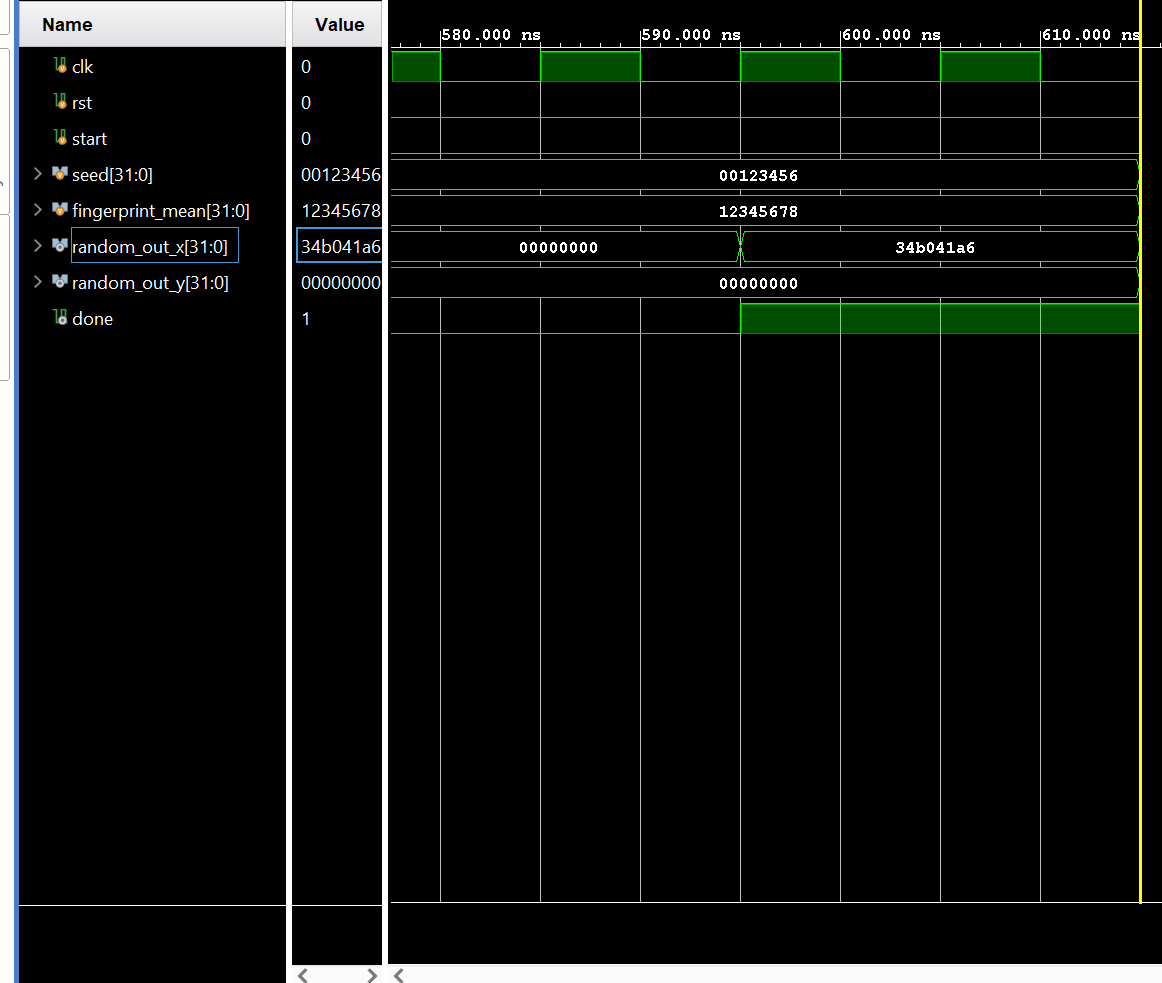
Fig 2: Testbench waveform

Using this code, we were able to identify and the data being generated from the Henon map to be of the right format. We then used a python script to test if the numbers were distributed randomly.

In [ ]:
# Hénon constants in Q1.31  (α = 1.4, β = 0.3)
A_Q31 = 0xB333_3333
B_Q31 = 0x2666_6666
ONE   = 0x8000_0000
MASK  = 0xFFFF_FFFF

# ------------------------------------------------------------
# 2.  Fixed-point helpers
# ------------------------------------------------------------
def q31_mul(a: int, b: int) -> int:
    """signed Q1.31 × Q1.31 → Q1.31"""
    prod = (a * b) & 0xFFFF_FFFF_FFFF_FFFF  # 64-bit wrap-around
    if prod & (1 << 63):                    # sign-extend
        prod -= 1 << 64
    return (prod >> 31) & MASK

def henon_q31(x: int, y: int):
    """one iteration of 2-D Hénon map"""
    x_sq = q31_mul(x, x)
    ax2  = q31_mul(A_Q31, x_sq)
    xn1  = (ONE - ax2 + y) & MASK
    yn1  = q31_mul(B_Q31, x)
    return xn1, yn1

# ------------------------------------------------------------
# 3.  Generate raw stream (no whitening)
# ------------------------------------------------------------
xs = np.empty(SAMPLES, dtype=np.uint32)
x, y = x0_q31, y0_q31
for i in range(SAMPLES):
    x, y = henon_q31(x, y)
    xs[i] = x                 # store raw x_n

# ------------------------------------------------------------
# 4.  Analyse bytes 0-2 (LSB .. byte-2)
# ------------------------------------------------------------
def analyse_byte(byte_vals, idx):
    hist  = np.bincount(byte_vals, minlength=256)
    chi2, p = stats.chisquare(hist, f_exp=np.full(256, hist.sum()/256))
    print(f"byte {idx}  χ² p-value = {p:.4f}")

    plt.figure()
    plt.hist(byte_vals, bins=256, color='orange')
    plt.title(f"Histogram – byte {idx} (shift {idx*8})")
    plt.xlabel("value 0-255"); plt.ylabel("count")
    plt.tight_layout()

for idx, shift in enumerate((0, 8, 16)):           # last three bytes
    analyse_byte((xs >> shift) & 0xFF, idx)

# ------------------------------------------------------------
# 5.  Histogram of the least-significant 24 bits  (uniform check)
# ------------------------------------------------------------
vals24 = xs & 0x00FF_FFFF         # keep only the lowest 24 bits

plt.figure()
# range=(0, 2**24) forces the x-axis to be the real 24-bit values
plt.hist(vals24, bins=256, range=(0, 2**24), color='orange')
plt.title("Histogram of the LSB-24 of xₙ  ({} samples)".format(SAMPLES))
plt.xlabel("24-bit value  (0x000000 … 0xFFFFFF)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(np.arange(1000), vals24[:1000], '.-', markersize=2)
plt.title("LSB-24 values versus iteration  (first 1 000)")
plt.xlabel("iteration"); plt.ylabel("24-bit value")
plt.tight_layout()

plt.show()

This provided us with a distrubtion as shown below which shows us the random nature of the PRNG.

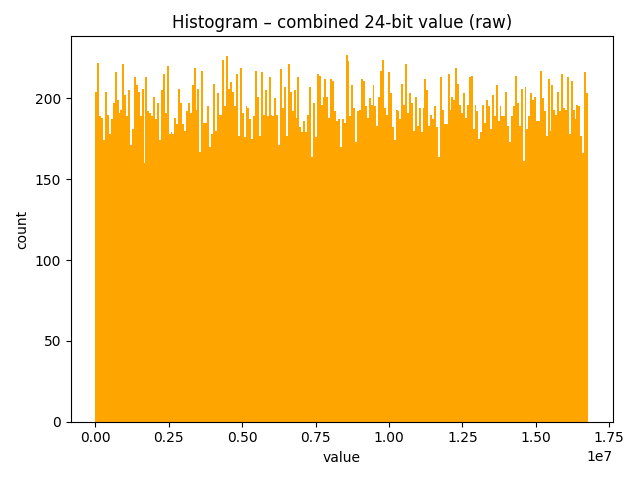

Fig 3: Plot of numbers from Henon Map

# Usage of AI and Design challenges



Ai was used mainly to verify code and to help document it more. Most of the challenge came from getting the system to sync up the 2 data streams, as the timings for the datas were in different frequencies, causing our Henon map to either have a large amount of starting signals being sent to it or none at all.

